In [1]:
import pandas as pd
import numpy as np
import os
import glob

Load both trade and book datasets

In [2]:
book_path = glob.glob('book_train.parquet/*')

In [3]:
trade_path = glob.glob('trade_train.parquet/*')

Extract both book and trade dataframes for stock id = 0 and run my code on it to test

In [4]:
book_train = pd.read_parquet(book_path[0])

In [5]:
trade_train = pd.read_parquet('trade_train.parquet')

In [6]:
book_train

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28


In [7]:
trade_example = pd.read_parquet(trade_path[0])

In [8]:
trade_example

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1
...,...,...,...,...,...
123438,32767,471,0.998659,200,3
123439,32767,517,0.998515,90,1
123440,32767,523,0.998563,1,1
123441,32767,542,0.998803,90,4


In [9]:
df_final = pd.DataFrame()

The idea is to extract some features from the book_train and others from trade_example, to do that first I need a column with the stock_id

In [101]:
stockid = book_path[0].split('=')[1]

In [102]:
trade_example['stock_id'] = stockid

In [103]:
trade_example.stock_id = trade_example.stock_id.astype(int)

In [104]:
book_train['stock_id'] = stockid
book_train.stock_id = book_train.stock_id.astype(int)

In [105]:
book_train

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
...,...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28,0
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28,0
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28,0
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28,0


# Feature engineering on trade_example

I'm interested in the volume and volume/count given the stock_id and time_id

In [106]:
trade_example['volume'] = trade_example['price']*trade_example['size']

In [107]:
trade_example['volume_per_count'] = trade_example['volume']/trade_example['order_count']

In [108]:
trade_grouped = trade_example.groupby(['stock_id','time_id'])

Given a specific stock_id and time_id, I would like to know how many seconds have passed and how much volume has been traded at each price change.

In [110]:
diff_seconds = trade_grouped['seconds_in_bucket'].diff()
diff_price = trade_grouped['price'].diff()
diff_volume = trade_grouped['volume'].diff()

In [111]:
trade_example['diff_price'] = diff_price
trade_example['diff_seconds'] = diff_seconds
trade_example['diff_volume'] = diff_volume

Useful features for **size** include the **total traded size**, the **mean**, the **maximum**, and the **variance**, given a specific time_id.

In [112]:
total_size = trade_grouped['size'].sum()
total_size = total_size.rename('total_size')
mean_size = trade_grouped['size'].mean()
mean_size = mean_size.rename('mean_size')
max_size = trade_grouped['size'].max()
max_size = max_size.rename('max_size')
min_size = trade_grouped['size'].min()
min_size = min_size.rename('min_size')
var_size = trade_grouped['size'].var()
var_size = var_size.rename('var_size')

Useful features for **price**

In [113]:
mean_price = trade_grouped['price'].mean()
mean_price = mean_price.rename('mean_price')
max_price = trade_grouped['price'].max()
max_price = max_price.rename('max_price')
min_price = trade_grouped['price'].min()
min_price = min_price.rename('min_price')
var_price = trade_grouped['price'].var()
var_price = var_price.rename('var_price')

Useful features for **volume**

In [114]:
total_volume = trade_grouped['volume'].sum()
total_volume = total_volume.rename('total_volume')
mean_volume = trade_grouped['volume'].mean()
mean_volume = mean_volume.rename('mean_volume')
max_volume = trade_grouped['volume'].max()
max_volume = max_volume.rename('max_volume')
min_volume = trade_grouped['volume'].min()
min_volume = min_volume.rename('min_volume')
var_volume = trade_grouped['volume'].var()
var_volume = var_volume.rename('var_volume')

Useful features for **order_count**

In [115]:
total_order_count = trade_grouped['order_count'].sum()
total_order_count = total_order_count.rename('total_order_count')
mean_order_count = trade_grouped['order_count'].mean()
mean_order_count = mean_order_count.rename('mean_order_count')
max_order_count = trade_grouped['order_count'].max()
max_order_count = max_order_count.rename('max_order_count')
min_order_count = trade_grouped['order_count'].min()
min_order_count = min_order_count.rename('min_order_count')
var_order_count = trade_grouped['order_count'].var()
var_order_count = var_order_count.rename('var_order_count')

**vwap**

In [116]:
vwap = total_volume/total_size
vwap = vwap.rename('vwap')

Useful features for **volume/count**

In [117]:
mean_vpc = trade_grouped['volume_per_count'].mean()
mean_vpc = mean_vpc.rename('mean_vpc')
max_vpc = trade_grouped['volume_per_count'].max()
max_vpc = max_vpc.rename('max_vpc')
min_vpc = trade_grouped['volume_per_count'].min()
min_vpc = min_vpc.rename('min_vpc')
var_vpc = trade_grouped['volume_per_count'].var()
var_vpc = var_vpc.rename('var_vpc')

Useful features for **diff_seconds**

In [118]:
mean_diff_sec = trade_grouped['diff_seconds'].mean()
mean_diff_sec = mean_diff_sec.rename('mean_diff_sec')
max_diff_sec = trade_grouped['diff_seconds'].max()
max_diff_sec = max_diff_sec.rename('max_diff_sec')
min_diff_sec = trade_grouped['diff_seconds'].min()
min_diff_sec = min_diff_sec.rename('min_diff_sec')
var_diff_sec = trade_grouped['diff_seconds'].var()
var_diff_sec = var_diff_sec.rename('var_diff_sec')

Useful features for **diff_price**

In [119]:
mean_diff_price = trade_grouped['diff_price'].mean()
mean_diff_price = mean_diff_price.rename('mean_diff_price')
max_diff_price = trade_grouped['diff_price'].max()
max_diff_price = max_diff_price.rename('max_diff_price')
min_diff_price = trade_grouped['diff_price'].min()
min_diff_price = min_diff_price.rename('min_diff_price')
var_diff_price = trade_grouped['diff_price'].var()
var_diff_price = var_diff_price.rename('var_diff_price')

Useful features for **diff_volume**

In [120]:
mean_diff_volume = trade_grouped['diff_volume'].mean()
mean_diff_volume = mean_diff_volume.rename('mean_diff_volume')
max_diff_volume = trade_grouped['diff_volume'].max()
max_diff_volume = max_diff_volume.rename('max_diff_volume')
min_diff_volume = trade_grouped['diff_volume'].min()
min_diff_volume = min_diff_volume.rename('min_diff_volume')
var_diff_volume = trade_grouped['diff_volume'].var()
var_diff_volume = var_diff_volume.rename('var_diff_volume')

# Merge everything

In [121]:
#[total_size,mean_size,max_size,min_size,var_size,mean_price,max_price,min_price,var_price,total_volume,mean_volume,max_volume,min_volume,var_volume,total_order_count,mean_order_count,max_order_count,min_order_count,var_order_count,vwap,mean_vpc,max_vpc,min_vpc,var_vpc,mean_diff_sec,max_diff_sec,min_diff_sec,var_diff_sec,mean_diff_price,max_diff_price,min_diff_price,var_diff_price,mean_diff_volume,max_diff_volume,min_diff_volume,var_diff_volume]

In [122]:
df = pd.concat([total_size,mean_size,max_size,min_size,var_size,mean_price,max_price,min_price,var_price,total_volume,mean_volume,max_volume,min_volume,var_volume,total_order_count,mean_order_count,max_order_count,min_order_count,var_order_count,vwap,mean_vpc,max_vpc,min_vpc,var_vpc,mean_diff_sec,max_diff_sec,min_diff_sec,var_diff_sec,mean_diff_price,max_diff_price,min_diff_price,var_diff_price,mean_diff_volume,max_diff_volume,min_diff_volume,var_diff_volume],names=['total_size','mean_size'],axis = 1).reset_index()

In [123]:
df

,stock_id,time_id,total_size,mean_size,max_size,min_size,var_size,mean_price,max_price,min_price,...,min_diff_sec,var_diff_sec,mean_diff_price,max_diff_price,min_diff_price,var_diff_price,mean_diff_volume,max_diff_volume,min_diff_volume,var_diff_volume
0,0,5,3179,79.475000,499,1,14012.666026,1.003722,1.004680,1.002301,...,1.0,160.307678,0.000034,0.000613,-0.000724,1.054531e-07,-7.709114,499.589769,-492.564661,33025.273919
1,0,11,1289,42.966667,280,1,6055.205747,1.000206,1.000828,0.999724,...,1.0,215.541870,0.000028,0.000402,-0.000251,2.819224e-08,7.038952,279.019784,-277.019082,12935.594254
2,0,16,2161,86.440000,391,1,12902.006667,0.999204,1.000455,0.997391,...,1.0,375.652222,-0.000106,0.000862,-0.000640,1.553238e-07,8.230635,377.456030,-380.461510,31064.860574
3,0,31,1962,130.800000,450,5,20975.314286,0.999020,1.000231,0.997972,...,1.0,1065.148315,-0.000161,0.000545,-0.000879,1.589643e-07,31.148895,390.204915,-367.523144,33851.877646
4,0,62,1791,81.409091,341,1,13903.872294,0.999618,1.000023,0.999231,...,1.0,306.347595,-0.000013,0.000332,-0.000559,3.775585e-08,1.571021,298.853386,-228.918219,23588.882792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0,32751,3450,66.346154,503,1,14147.877828,0.997556,0.998751,0.996358,...,1.0,190.986725,-0.000030,0.000364,-0.000520,4.504261e-08,1.503846,483.835757,-500.788621,31297.124115
3826,0,32753,4547,162.392857,772,1,47718.395503,1.000325,1.001227,0.999474,...,1.0,296.413116,0.000032,0.000516,-0.000544,7.564632e-08,-7.844172,636.830504,-767.731356,114287.240931
3827,0,32758,4250,118.055556,601,1,19973.768254,0.999633,1.000705,0.998438,...,1.0,483.314270,0.000042,0.000598,-0.000378,6.616718e-08,0.057199,299.793632,-599.435665,38602.676391
3828,0,32763,3217,60.698113,383,1,6573.599419,1.002305,1.003003,1.001611,...,1.0,94.779419,0.000008,0.000593,-0.000573,6.332624e-08,1.888483,283.553058,-363.755933,9835.064503


In [124]:
df2 = pd.concat([total_size,mean_size,max_size,min_size,var_size,mean_price,max_price,min_price,var_price,total_volume,mean_volume,max_volume,min_volume,var_volume,total_order_count,mean_order_count,max_order_count,min_order_count,var_order_count,vwap,mean_vpc,max_vpc,min_vpc,var_vpc,mean_diff_sec,max_diff_sec,min_diff_sec,var_diff_sec,mean_diff_price,max_diff_price,min_diff_price,var_diff_price,mean_diff_volume,max_diff_volume,min_diff_volume,var_diff_volume],names=['total_size','mean_size'],axis = 1).reset_index()

In [125]:
df2

,stock_id,time_id,total_size,mean_size,max_size,min_size,var_size,mean_price,max_price,min_price,...,min_diff_sec,var_diff_sec,mean_diff_price,max_diff_price,min_diff_price,var_diff_price,mean_diff_volume,max_diff_volume,min_diff_volume,var_diff_volume
0,0,5,3179,79.475000,499,1,14012.666026,1.003722,1.004680,1.002301,...,1.0,160.307678,0.000034,0.000613,-0.000724,1.054531e-07,-7.709114,499.589769,-492.564661,33025.273919
1,0,11,1289,42.966667,280,1,6055.205747,1.000206,1.000828,0.999724,...,1.0,215.541870,0.000028,0.000402,-0.000251,2.819224e-08,7.038952,279.019784,-277.019082,12935.594254
2,0,16,2161,86.440000,391,1,12902.006667,0.999204,1.000455,0.997391,...,1.0,375.652222,-0.000106,0.000862,-0.000640,1.553238e-07,8.230635,377.456030,-380.461510,31064.860574
3,0,31,1962,130.800000,450,5,20975.314286,0.999020,1.000231,0.997972,...,1.0,1065.148315,-0.000161,0.000545,-0.000879,1.589643e-07,31.148895,390.204915,-367.523144,33851.877646
4,0,62,1791,81.409091,341,1,13903.872294,0.999618,1.000023,0.999231,...,1.0,306.347595,-0.000013,0.000332,-0.000559,3.775585e-08,1.571021,298.853386,-228.918219,23588.882792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,0,32751,3450,66.346154,503,1,14147.877828,0.997556,0.998751,0.996358,...,1.0,190.986725,-0.000030,0.000364,-0.000520,4.504261e-08,1.503846,483.835757,-500.788621,31297.124115
3826,0,32753,4547,162.392857,772,1,47718.395503,1.000325,1.001227,0.999474,...,1.0,296.413116,0.000032,0.000516,-0.000544,7.564632e-08,-7.844172,636.830504,-767.731356,114287.240931
3827,0,32758,4250,118.055556,601,1,19973.768254,0.999633,1.000705,0.998438,...,1.0,483.314270,0.000042,0.000598,-0.000378,6.616718e-08,0.057199,299.793632,-599.435665,38602.676391
3828,0,32763,3217,60.698113,383,1,6573.599419,1.002305,1.003003,1.001611,...,1.0,94.779419,0.000008,0.000593,-0.000573,6.332624e-08,1.888483,283.553058,-363.755933,9835.064503


In [126]:
df3 = pd.DataFrame()

# Features engineering on book_train and variables to compute the volatility

In [127]:
book_train

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
...,...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28,0
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28,0
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28,0
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28,0


Optiver definition of **BidAskSpread**

In [128]:
book_train['BidAskSpreadOpt'] = (book_train['ask_price1']/book_train['bid_price1'])-1

**wap**: weighted average price

In [129]:
book_train['wap'] = ((book_train['bid_price1']*book_train['ask_size1'])+(book_train['ask_price1']*book_train['bid_size1']))/(book_train['bid_size1']+book_train['ask_size1'])

**supply**: number of stocks available to be bought

In [130]:
book_train['supply'] = (book_train['ask_price1']*book_train['ask_size1'])+(book_train['ask_price2']*book_train['ask_size2'])

**pot_demand**: Essentially, they are buy limit orders.

In [131]:
book_train['pot_demand'] = (book_train['bid_price1']*book_train['bid_size1'])+(book_train['bid_price2']*book_train['bid_size2'])

**bid_price1_2** difference between the bid prices

In [132]:
book_train['bid_price1_2'] = book_train['bid_price1'] - book_train['bid_price2']

**ask_price1_2** difference between the ask prices

In [133]:
book_train['ask_price1_2'] = book_train['ask_price1'] - book_train['ask_price2']

**bid_size1_2** differenze between the bid sizes

In [134]:
book_train['bid_size1_2'] = book_train['bid_size1'] - book_train['bid_size2']

**ask_size1_2** differenze between the ask sizes

In [135]:
book_train['ask_size1_2'] = book_train['ask_size1'] - book_train['ask_size2']

In [136]:
book_grouped = book_train.groupby(['stock_id','time_id'])

In [137]:
book_train['log_wap'] = np.log(book_train['wap'])

In [138]:
book_train['log_diff'] = book_grouped['log_wap'].diff()

In [139]:
book_train['log_diff'] = book_train['log_diff'].replace(np.NaN,0)

In [140]:
book_train['log_diff^2'] = book_train['log_diff']**2

In [141]:
book_train['bid_diff1'] = book_grouped['bid_price1'].diff()

In [142]:
book_train['bid_diff2'] = book_grouped['bid_price2'].diff()

In [143]:
book_train['ask_diff1'] = book_grouped['ask_price1'].diff()

In [144]:
book_train['ask_diff2'] = book_grouped['ask_price2'].diff()

In [145]:
book_train['bid_size_diff1'] = book_grouped['bid_size1'].diff()

In [146]:
book_train['bid_size_diff2'] = book_grouped['bid_size2'].diff()

In [147]:
book_train['ask_size_diff1'] = book_grouped['ask_size1'].diff()

In [148]:
book_train['ask_size_diff2'] = book_grouped['ask_size2'].diff()

# Compute all the features needed

In [149]:
df_book = pd.DataFrame()

In [150]:
df_book

""


Useful features for **ask_price1**

In [151]:
mean_ask_price1 = book_grouped['ask_price1'].mean()
max_ask_price1 = book_grouped['ask_price1'].max()
min_ask_price1 = book_grouped['ask_price1'].min()
var_ask_price1 = book_grouped['ask_price1'].var()

In [152]:
df_book['mean_ask_price1'] = mean_ask_price1
df_book['max_ask_price1'] = max_ask_price1
df_book['min_ask_price1'] = min_ask_price1
df_book['var_ask_price1'] = var_ask_price1

useful features for **ask_price2**

In [153]:
mean_ask_price2 = book_grouped['ask_price2'].mean()
max_ask_price2 = book_grouped['ask_price2'].max()
min_ask_price2 = book_grouped['ask_price2'].min()
var_ask_price2 = book_grouped['ask_price2'].var()

In [154]:
df_book['mean_ask_price2'] = mean_ask_price1
df_book['max_ask_price2'] = max_ask_price2
df_book['min_ask_price2'] = min_ask_price2
df_book['var_ask_price2'] = var_ask_price2

Useful features for **bid_price1**

In [155]:
mean_bid_price1 = book_grouped['bid_price1'].mean()
max_bid_price1 = book_grouped['bid_price1'].max()
min_bid_price1 = book_grouped['bid_price1'].min()
var_bid_price1 = book_grouped['bid_price1'].var()

In [156]:
df_book['mean_bid_price1'] = mean_bid_price1
df_book['max_bid_price1'] = max_bid_price1
df_book['min_bid_price1'] = min_bid_price1
df_book['var_bid_price1'] = var_bid_price1

Useful features for **bid_price2**

In [157]:
mean_bid_price2 = book_grouped['bid_price2'].mean()
max_bid_price2 = book_grouped['bid_price2'].max()
min_bid_price2 = book_grouped['bid_price2'].min()
var_bid_price2 = book_grouped['bid_price2'].var()

In [158]:
df_book['mean_bid_price2'] = mean_bid_price2
df_book['max_bid_price2'] = max_bid_price2
df_book['min_bid_price2'] = min_bid_price2
df_book['var_bid_price2'] = var_bid_price2

Useful features for **ask_size1**

In [159]:
mean_ask_size1 = book_grouped['ask_size1'].mean()
max_ask_size1 = book_grouped['ask_size1'].max()
min_ask_size1 = book_grouped['ask_size1'].min()
var_ask_size1 = book_grouped['ask_size1'].var()

In [160]:
df_book['mean_ask_size1'] = mean_ask_size1
df_book['max_ask_size1'] = max_ask_size1
df_book['min_ask_size1'] = min_ask_size1
df_book['var_ask_size1'] = var_ask_size1

Useful features for **ask_size2**

In [161]:
mean_ask_size2 = book_grouped['ask_size2'].mean()
max_ask_size2 = book_grouped['ask_size2'].max()
min_ask_size2 = book_grouped['ask_size2'].min()
var_ask_size2 = book_grouped['ask_size2'].var()

In [162]:
df_book['mean_ask_size2'] = mean_ask_size2
df_book['max_ask_size2'] = max_ask_size2
df_book['min_ask_size2'] = min_ask_size2
df_book['var_ask_size2'] = var_ask_size2

Useful features for **bid_size1**

In [163]:
mean_bid_size1 = book_grouped['bid_size1'].mean()
max_bid_size1 = book_grouped['bid_size1'].max()
min_bid_size1 = book_grouped['bid_size1'].min()
var_bid_size1 = book_grouped['bid_size1'].var()

In [164]:
df_book['mean_bid_size1'] = mean_bid_size1
df_book['max_bid_size1'] = max_bid_size1
df_book['min_bid_size1'] = min_bid_size1
df_book['var_bid_size1'] = var_bid_size1

Useful features for **bid_size2**

In [165]:
mean_bid_size2 = book_grouped['bid_size2'].mean()
max_bid_size2 = book_grouped['bid_size2'].max()
min_bid_size2 = book_grouped['bid_size2'].min()
var_bid_size2 = book_grouped['bid_size2'].var()

In [166]:
df_book['mean_bid_size2'] = mean_bid_size2
df_book['max_bid_size2'] = max_bid_size2
df_book['min_bid_size2'] = min_bid_size2
df_book['var_bid_size2'] = var_bid_size2

Useful features for **supply**

In [167]:
mean_supply = book_grouped['supply'].mean()
max_supply = book_grouped['supply'].max()
min_supply = book_grouped['supply'].min()
var_supply = book_grouped['supply'].var()

In [168]:
df_book['mean_supply'] = mean_supply
df_book['max_supply'] = max_supply
df_book['min_supply'] = min_supply
df_book['var_supply'] = var_supply

Useful features for **pot_demand**

In [169]:
mean_pot_demand = book_grouped['pot_demand'].mean()
max_pot_demand = book_grouped['pot_demand'].max()
min_pot_demand = book_grouped['pot_demand'].min()
var_pot_demand = book_grouped['pot_demand'].var()

In [170]:
df_book['mean_pot_demand'] = mean_pot_demand
df_book['max_pot_demand'] = max_pot_demand
df_book['min_pot_demand'] = min_pot_demand
df_book['var_pot_demand'] = var_pot_demand

Useful features for **bid_price1_2**

In [171]:
mean_bid_price1_2 = book_grouped['bid_price1_2'].mean()
max_bid_price1_2 = book_grouped['bid_price1_2'].max()
min_bid_price1_2 = book_grouped['bid_price1_2'].min()
var_bid_price1_2 = book_grouped['bid_price1_2'].var()

In [172]:
df_book['mean_bid_price1_2'] = mean_bid_price1_2
df_book['max_bid_price1_2'] = max_bid_price1_2
df_book['min_bid_price1_2'] = min_bid_price1_2
df_book['var_bid_price1_2'] = var_bid_price1_2

Useful features for **ask_price1_2**

In [173]:
mean_ask_price1_2 = book_grouped['ask_price1_2'].mean()
max_ask_price1_2 = book_grouped['ask_price1_2'].max()
min_ask_price1_2 = book_grouped['ask_price1_2'].min()
var_ask_price1_2 = book_grouped['ask_price1_2'].var()

In [174]:
df_book['mean_ask_price1_2'] = mean_ask_price1_2
df_book['max_ask_price1_2'] = max_ask_price1_2
df_book['min_ask_price1_2'] = min_ask_price1_2
df_book['var_ask_price1_2'] = var_ask_price1_2

Useful features for **bid_size1_2**

In [175]:
mean_bid_size1_2 = book_grouped['bid_size1_2'].mean()
max_bid_size1_2 = book_grouped['bid_size1_2'].max()
min_bid_size1_2 = book_grouped['bid_size1_2'].min()
var_bid_size1_2 = book_grouped['bid_size1_2'].var()

In [176]:
df_book['mean_bid_size1_2'] = mean_bid_size1_2
df_book['max_bid_size1_2'] = max_bid_size1_2
df_book['min_bid_size1_2'] = min_bid_size1_2
df_book['var_bid_size1_2'] = var_bid_size1_2

Useful features for **ask_size1_2**

In [177]:
mean_ask_size1_2 = book_grouped['ask_size1_2'].mean()
max_ask_size1_2 = book_grouped['ask_size1_2'].max()
min_ask_size1_2 = book_grouped['ask_size1_2'].min()
var_ask_size1_2 = book_grouped['ask_size1_2'].var()

In [178]:
df_book['mean_ask_size1_2'] = mean_ask_size1_2
df_book['max_ask_size1_2'] = max_ask_size1_2
df_book['min_ask_size1_2'] = min_ask_size1_2
df_book['var_ask_size1_2'] = var_ask_size1_2

Useful features for **BidAskSpreadOpt**

In [179]:
mean_BidAskSpreadOpt = book_grouped['BidAskSpreadOpt'].mean()
max_BidAskSpreadOpt = book_grouped['BidAskSpreadOpt'].max()
min_BidAskSpreadOpt = book_grouped['BidAskSpreadOpt'].min()
var_BidAskSpreadOpt = book_grouped['BidAskSpreadOpt'].var()

In [180]:
df_book['mean_BidAskSpreadOpt'] = mean_BidAskSpreadOpt
df_book['max_BidAskSpreadOpt'] = max_BidAskSpreadOpt
df_book['min_BidAskSpreadOpt'] = min_BidAskSpreadOpt
df_book['var_BidAskSpreadOpt'] = var_BidAskSpreadOpt

Useful features for **wap**

In [181]:
mean_wap = book_grouped['wap'].mean()
max_wap = book_grouped['wap'].max()
min_wap = book_grouped['wap'].min()
var_wap = book_grouped['wap'].var()

In [182]:
df_book['mean_wap'] = mean_wap
df_book['max_wap'] = max_wap
df_book['min_wap'] = min_wap
df_book['var_wap'] = var_wap

# compute realized volatility (target)

In [183]:
current_realized_volatility = (book_grouped['log_diff^2'].sum())**(0.5)

In [184]:
df_book['current_realized_volatility'] = current_realized_volatility

Useful features for **bid_diff1**

In [185]:
mean_bid_diff1 = book_grouped['bid_diff1'].mean()
max_bid_diff1 = book_grouped['bid_diff1'].max()
min_bid_diff1 = book_grouped['bid_diff1'].min()
var_bid_diff1 = book_grouped['bid_diff1'].var()

In [186]:
df_book['mean_bid_diff1'] = mean_bid_diff1
df_book['max_bid_diff1'] = max_bid_diff1
df_book['min_bid_diff1'] = min_bid_diff1
df_book['var_bid_diff1'] = var_bid_diff1

Useful features for **bid_diff2**

In [187]:
mean_bid_diff2 = book_grouped['bid_diff2'].mean()
max_bid_diff2 = book_grouped['bid_diff2'].max()
min_bid_diff2 = book_grouped['bid_diff2'].min()
var_bid_diff2 = book_grouped['bid_diff2'].var()

In [188]:
df_book['mean_bid_diff2'] = mean_bid_diff2
df_book['max_bid_diff2'] = max_bid_diff2
df_book['min_bid_diff2'] = min_bid_diff2
df_book['var_bid_diff2'] = var_bid_diff2

Useful features for **ask_diff1**

In [189]:
mean_ask_diff1 = book_grouped['ask_diff1'].mean()
max_ask_diff1 = book_grouped['ask_diff1'].max()
min_ask_diff1 = book_grouped['ask_diff1'].min()
var_ask_diff1 = book_grouped['ask_diff1'].var()

In [190]:
df_book['mean_ask_diff1'] = mean_ask_diff1
df_book['max_ask_diff1'] = max_ask_diff1
df_book['min_ask_diff1'] = min_ask_diff1
df_book['var_ask_diff1'] = var_ask_diff1

Useful features for **bid_size_diff1**

In [191]:
mean_bid_size_diff1 = book_grouped['bid_size_diff1'].mean()
max_bid_size_diff1 = book_grouped['bid_size_diff1'].max()
min_bid_size_diff1 = book_grouped['bid_size_diff1'].min()
var_bid_size_diff1 = book_grouped['bid_size_diff1'].var()

In [192]:
df_book['mean_bid_size_diff1'] = mean_bid_size_diff1
df_book['max_bid_size_diff1'] = max_bid_size_diff1
df_book['min_bid_size_diff1'] = min_bid_size_diff1
df_book['var_bid_size_diff1'] = var_bid_size_diff1

Useful features for **bid_size_diff2**

In [193]:
mean_bid_size_diff2 = book_grouped['bid_size_diff2'].mean()
max_bid_size_diff2 = book_grouped['bid_size_diff2'].max()
min_bid_size_diff2 = book_grouped['bid_size_diff2'].min()
var_bid_size_diff2 = book_grouped['bid_size_diff2'].var()

In [194]:
df_book['mean_bid_size_diff2'] = mean_bid_size_diff2
df_book['max_bid_size_diff2'] = max_bid_size_diff2
df_book['min_bid_size_diff2'] = min_bid_size_diff2
df_book['var_bid_size_diff2'] = var_bid_size_diff2

Useful features for **ask_size_diff1**

In [195]:
mean_ask_size_diff1 = book_grouped['ask_size_diff1'].mean()
max_ask_size_diff1 = book_grouped['ask_size_diff1'].max()
min_ask_size_diff1 = book_grouped['ask_size_diff1'].min()
var_ask_size_diff1 = book_grouped['ask_size_diff1'].var()

In [196]:
df_book['mean_ask_size_diff1'] = mean_ask_size_diff1
df_book['max_ask_size_diff1'] = max_ask_size_diff1
df_book['min_ask_size_diff1'] = min_ask_size_diff1
df_book['var_ask_size_diff1'] = var_ask_size_diff1

Useful features for **ask_size_diff2**

In [197]:
mean_ask_size_diff2 = book_grouped['ask_size_diff2'].mean()
max_ask_size_diff2 = book_grouped['ask_size_diff2'].max()
min_ask_size_diff2 = book_grouped['ask_size_diff2'].min()
var_ask_size_diff2 = book_grouped['ask_size_diff2'].var()

In [198]:
df_book['mean_ask_size_diff2'] = mean_ask_size_diff2
df_book['max_ask_size_diff2'] = max_ask_size_diff2
df_book['min_ask_size_diff2'] = min_ask_size_diff2
df_book['var_ask_size_diff2'] = var_ask_size_diff2

# Compute on all the stocks on the trade_set

In [204]:
df_final = pd.DataFrame()
for file in trade_path:
    trade_example = pd.read_parquet(file)
    stockid = file.split('=')[1]
    trade_example['stock_id'] = stockid
    trade_example.stock_id = trade_example.stock_id.astype(int)
    trade_example['volume'] = trade_example['price']*trade_example['size']
    trade_example['volume_per_count'] = trade_example['volume']/trade_example['order_count']
    trade_grouped = trade_example.groupby(['stock_id','time_id'])
    diff_seconds = trade_grouped['seconds_in_bucket'].diff()
    diff_price = trade_grouped['price'].diff()
    diff_volume = trade_grouped['volume'].diff()
    trade_example['diff_price'] = diff_price
    trade_example['diff_seconds'] = diff_seconds
    trade_example['diff_volume'] = diff_volume
    total_size = trade_grouped['size'].sum()
    total_size = total_size.rename('total_size')
    mean_size = trade_grouped['size'].mean()
    mean_size = mean_size.rename('mean_size')
    max_size = trade_grouped['size'].max()
    max_size = max_size.rename('max_size')
    min_size = trade_grouped['size'].min()
    min_size = min_size.rename('min_size')
    var_size = trade_grouped['size'].var()
    var_size = var_size.rename('var_size')
    mean_price = trade_grouped['price'].mean()
    mean_price = mean_price.rename('mean_price')
    max_price = trade_grouped['price'].max()
    max_price = max_price.rename('max_price')
    min_price = trade_grouped['price'].min()
    min_price = min_price.rename('min_price')
    var_price = trade_grouped['price'].var()
    var_price = var_price.rename('var_price')
    total_volume = trade_grouped['volume'].sum()
    total_volume = total_volume.rename('total_volume')
    mean_volume = trade_grouped['volume'].mean()
    mean_volume = mean_volume.rename('mean_volume')
    max_volume = trade_grouped['volume'].max()
    max_volume = max_volume.rename('max_volume')
    min_volume = trade_grouped['volume'].min()
    min_volume = min_volume.rename('min_volume')
    var_volume = trade_grouped['volume'].var()
    var_volume = var_volume.rename('var_volume')
    total_order_count = trade_grouped['order_count'].sum()
    total_order_count = total_order_count.rename('total_order_count')
    mean_order_count = trade_grouped['order_count'].mean()
    mean_order_count = mean_order_count.rename('mean_order_count')
    max_order_count = trade_grouped['order_count'].max()
    max_order_count = max_order_count.rename('max_order_count')
    min_order_count = trade_grouped['order_count'].min()
    min_order_count = min_order_count.rename('min_order_count')
    var_order_count = trade_grouped['order_count'].var()
    var_order_count = var_order_count.rename('var_order_count')
    vwap = total_volume/total_size
    vwap = vwap.rename('vwap')
    mean_vpc = trade_grouped['volume_per_count'].mean()
    mean_vpc = mean_vpc.rename('mean_vpc')
    max_vpc = trade_grouped['volume_per_count'].max()
    max_vpc = max_vpc.rename('max_vpc')
    min_vpc = trade_grouped['volume_per_count'].min()
    min_vpc = min_vpc.rename('min_vpc')
    var_vpc = trade_grouped['volume_per_count'].var()
    var_vpc = var_vpc.rename('var_vpc')
    mean_diff_sec = trade_grouped['diff_seconds'].mean()
    mean_diff_sec = mean_diff_sec.rename('mean_diff_sec')
    max_diff_sec = trade_grouped['diff_seconds'].max()
    max_diff_sec = max_diff_sec.rename('max_diff_sec')
    min_diff_sec = trade_grouped['diff_seconds'].min()
    min_diff_sec = min_diff_sec.rename('min_diff_sec')
    var_diff_sec = trade_grouped['diff_seconds'].var()
    var_diff_sec = var_diff_sec.rename('var_diff_sec')
    mean_diff_price = trade_grouped['diff_price'].mean()
    mean_diff_price = mean_diff_price.rename('mean_diff_price')
    max_diff_price = trade_grouped['diff_price'].max()
    max_diff_price = max_diff_price.rename('max_diff_price')
    min_diff_price = trade_grouped['diff_price'].min()
    min_diff_price = min_diff_price.rename('min_diff_price')
    var_diff_price = trade_grouped['diff_price'].var()
    var_diff_price = var_diff_price.rename('var_diff_price')
    mean_diff_volume = trade_grouped['diff_volume'].mean()
    mean_diff_volume = mean_diff_volume.rename('mean_diff_volume')
    max_diff_volume = trade_grouped['diff_volume'].max()
    max_diff_volume = max_diff_volume.rename('max_diff_volume')
    min_diff_volume = trade_grouped['diff_volume'].min()
    min_diff_volume = min_diff_volume.rename('min_diff_volume')
    var_diff_volume = trade_grouped['diff_volume'].var()
    var_diff_volume = var_diff_volume.rename('var_diff_volume')
    df_trade = pd.concat([total_size,mean_size,max_size,min_size,var_size,mean_price,max_price,min_price,var_price,total_volume,mean_volume,max_volume,min_volume,var_volume,total_order_count,mean_order_count,max_order_count,min_order_count,var_order_count,vwap,mean_vpc,max_vpc,min_vpc,var_vpc,mean_diff_sec,max_diff_sec,min_diff_sec,var_diff_sec,mean_diff_price,max_diff_price,min_diff_price,var_diff_price,mean_diff_volume,max_diff_volume,min_diff_volume,var_diff_volume],axis = 1).reset_index()
    df_final = pd.concat([df_final,df_trade],ignore_index = True)

In [205]:
df_final

,stock_id,time_id,total_size,mean_size,max_size,min_size,var_size,mean_price,max_price,min_price,...,min_diff_sec,var_diff_sec,mean_diff_price,max_diff_price,min_diff_price,var_diff_price,mean_diff_volume,max_diff_volume,min_diff_volume,var_diff_volume
0,0,5,3179,79.475000,499,1,1.401267e+04,1.003722,1.004680,1.002301,...,1.0,160.307678,0.000034,0.000613,-0.000724,1.054531e-07,-7.709114,499.589769,-492.564661,3.302527e+04
1,0,11,1289,42.966667,280,1,6.055206e+03,1.000206,1.000828,0.999724,...,1.0,215.541870,0.000028,0.000402,-0.000251,2.819224e-08,7.038952,279.019784,-277.019082,1.293559e+04
2,0,16,2161,86.440000,391,1,1.290201e+04,0.999204,1.000455,0.997391,...,1.0,375.652222,-0.000106,0.000862,-0.000640,1.553238e-07,8.230635,377.456030,-380.461510,3.106486e+04
3,0,31,1962,130.800000,450,5,2.097531e+04,0.999020,1.000231,0.997972,...,1.0,1065.148315,-0.000161,0.000545,-0.000879,1.589643e-07,31.148895,390.204915,-367.523144,3.385188e+04
4,0,62,1791,81.409091,341,1,1.390387e+04,0.999618,1.000023,0.999231,...,1.0,306.347595,-0.000013,0.000332,-0.000559,3.775585e-08,1.571021,298.853386,-228.918219,2.358888e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428908,99,32751,48894,474.699029,2919,1,2.852014e+05,1.000635,1.001145,0.999631,...,1.0,69.406723,0.000003,0.000326,-0.000235,1.282320e-08,-8.250927,2620.126893,-2843.308061,4.971280e+05
428909,99,32753,48635,528.641304,4220,1,5.152063e+05,1.000694,1.002271,0.999602,...,1.0,66.941376,0.000003,0.000738,-0.000283,2.596360e-08,3.188549,4111.640220,-3177.923767,9.122206e+05
428910,99,32758,50438,600.452381,9432,1,1.387562e+06,0.998246,0.999918,0.997636,...,1.0,48.360275,-0.000028,0.000326,-0.000326,2.315047e-08,26.500700,9312.929113,-8123.434905,2.660668e+06
428911,99,32763,47020,283.253012,2914,1,1.389043e+05,0.998905,0.999938,0.998192,...,1.0,9.669473,-0.000005,0.000324,-0.000428,1.920218e-08,-0.539424,2311.827872,-2712.502860,2.859345e+05


# Compute on all the stocks on the book_set

In [89]:
df_final2 = pd.DataFrame()
for file in book_path:
    df_book = pd.DataFrame()
    book_train = pd.read_parquet(file)
    stockid = file.split('=')[1]
    book_train['stock_id'] = stockid
    book_train.stock_id = book_train.stock_id.astype(int)
    book_train['BidAskSpreadOpt'] = (book_train['ask_price1']/book_train['bid_price1'])-1
    book_train['wap'] = ((book_train['bid_price1']*book_train['ask_size1'])+(book_train['ask_price1']*book_train['bid_size1']))/(book_train['bid_size1']+book_train['ask_size1'])
    book_train['supply'] = (book_train['ask_price1']*book_train['ask_size1'])+(book_train['ask_price2']*book_train['ask_size2'])
    book_train['pot_demand'] = (book_train['bid_price1']*book_train['bid_size1'])+(book_train['bid_price2']*book_train['bid_size2'])
    book_train['bid_price1_2'] = book_train['bid_price1'] - book_train['bid_price2']
    book_train['ask_price1_2'] = book_train['ask_price1'] - book_train['ask_price2']
    book_train['bid_size1_2'] = book_train['bid_size1'] - book_train['bid_size2']
    book_train['ask_size1_2'] = book_train['ask_size1'] - book_train['ask_size2']
    book_grouped = book_train.groupby(['stock_id','time_id'])
    book_train['log_wap'] = np.log(book_train['wap'])
    book_train['log_diff'] = book_grouped['log_wap'].diff()
    book_train['log_diff'] = book_train['log_diff'].replace(np.NaN,0)
    book_train['log_diff^2'] = book_train['log_diff']**2
    book_train['bid_diff1'] = book_grouped['bid_price1'].diff()
    book_train['bid_diff2'] = book_grouped['bid_price2'].diff()
    book_train['ask_diff1'] = book_grouped['ask_price1'].diff()
    book_train['ask_diff2'] = book_grouped['ask_price2'].diff()
    book_train['bid_size_diff1'] = book_grouped['bid_size1'].diff()
    book_train['bid_size_diff2'] = book_grouped['bid_size2'].diff()
    book_train['ask_size_diff1'] = book_grouped['ask_size1'].diff()
    book_train['ask_size_diff2'] = book_grouped['ask_size2'].diff()
    mean_ask_price1 = book_grouped['ask_price1'].mean()
    max_ask_price1 = book_grouped['ask_price1'].max()
    min_ask_price1 = book_grouped['ask_price1'].min()
    var_ask_price1 = book_grouped['ask_price1'].var()
    df_book['mean_ask_price1'] = mean_ask_price1
    df_book['max_ask_price1'] = max_ask_price1
    df_book['min_ask_price1'] = min_ask_price1
    df_book['var_ask_price1'] = var_ask_price1
    mean_ask_price2 = book_grouped['ask_price2'].mean()
    max_ask_price2 = book_grouped['ask_price2'].max()
    min_ask_price2 = book_grouped['ask_price2'].min()
    var_ask_price2 = book_grouped['ask_price2'].var()
    df_book['mean_ask_price2'] = mean_ask_price2
    df_book['max_ask_price2'] = max_ask_price2
    df_book['min_ask_price2'] = min_ask_price2
    df_book['var_ask_price2'] = var_ask_price2
    mean_bid_price1 = book_grouped['bid_price1'].mean()
    max_bid_price1 = book_grouped['bid_price1'].max()
    min_bid_price1 = book_grouped['bid_price1'].min()
    var_bid_price1 = book_grouped['bid_price1'].var()
    df_book['mean_bid_price1'] = mean_bid_price1
    df_book['max_bid_price1'] = max_bid_price1
    df_book['min_bid_price1'] = min_bid_price1
    df_book['var_bid_price1'] = var_bid_price1
    mean_bid_price2 = book_grouped['bid_price2'].mean()
    max_bid_price2 = book_grouped['bid_price2'].max()
    min_bid_price2 = book_grouped['bid_price2'].min()
    var_bid_price2 = book_grouped['bid_price2'].var()
    df_book['mean_bid_price2'] = mean_bid_price2
    df_book['max_bid_price2'] = max_bid_price2
    df_book['min_bid_price2'] = min_bid_price2
    df_book['var_bid_price2'] = var_bid_price2
    mean_ask_size1 = book_grouped['ask_size1'].mean()
    max_ask_size1 = book_grouped['ask_size1'].max()
    min_ask_size1 = book_grouped['ask_size1'].min()
    var_ask_size1 = book_grouped['ask_size1'].var()
    df_book['mean_ask_size1'] = mean_ask_size1
    df_book['max_ask_size1'] = max_ask_size1
    df_book['min_ask_size1'] = min_ask_size1
    df_book['var_ask_size1'] = var_ask_size1
    mean_ask_size2 = book_grouped['ask_size2'].mean()
    max_ask_size2 = book_grouped['ask_size2'].max()
    min_ask_size2 = book_grouped['ask_size2'].min()
    var_ask_size2 = book_grouped['ask_size2'].var()
    df_book['mean_ask_size2'] = mean_ask_size2
    df_book['max_ask_size2'] = max_ask_size2
    df_book['min_ask_size2'] = min_ask_size2
    df_book['var_ask_size2'] = var_ask_size2
    mean_bid_size1 = book_grouped['bid_size1'].mean()
    max_bid_size1 = book_grouped['bid_size1'].max()
    min_bid_size1 = book_grouped['bid_size1'].min()
    var_bid_size1 = book_grouped['bid_size1'].var()
    df_book['mean_bid_size1'] = mean_bid_size1
    df_book['max_bid_size1'] = max_bid_size1
    df_book['min_bid_size1'] = min_bid_size1
    df_book['var_bid_size1'] = var_bid_size1
    mean_bid_size2 = book_grouped['bid_size2'].mean()
    max_bid_size2 = book_grouped['bid_size2'].max()
    min_bid_size2 = book_grouped['bid_size2'].min()
    var_bid_size2 = book_grouped['bid_size2'].var()
    df_book['mean_bid_size2'] = mean_bid_size2
    df_book['max_bid_size2'] = max_bid_size2
    df_book['min_bid_size2'] = min_bid_size2
    df_book['var_bid_size2'] = var_bid_size2
    mean_supply = book_grouped['supply'].mean()
    max_supply = book_grouped['supply'].max()
    min_supply = book_grouped['supply'].min()
    var_supply = book_grouped['supply'].var()
    df_book['mean_supply'] = mean_supply
    df_book['max_supply'] = max_supply
    df_book['min_supply'] = min_supply
    df_book['var_supply'] = var_supply
    mean_pot_demand = book_grouped['pot_demand'].mean()
    max_pot_demand = book_grouped['pot_demand'].max()
    min_pot_demand = book_grouped['pot_demand'].min()
    var_pot_demand = book_grouped['pot_demand'].var()
    df_book['mean_pot_demand'] = mean_pot_demand
    df_book['max_pot_demand'] = max_pot_demand
    df_book['min_pot_demand'] = min_pot_demand
    df_book['var_pot_demand'] = var_pot_demand
    mean_bid_price1_2 = book_grouped['bid_price1_2'].mean()
    max_bid_price1_2 = book_grouped['bid_price1_2'].max()
    min_bid_price1_2 = book_grouped['bid_price1_2'].min()
    var_bid_price1_2 = book_grouped['bid_price1_2'].var()
    df_book['mean_bid_price1_2'] = mean_bid_price1_2
    df_book['max_bid_price1_2'] = max_bid_price1_2
    df_book['min_bid_price1_2'] = min_bid_price1_2
    df_book['var_bid_price1_2'] = var_bid_price1_2
    mean_ask_price1_2 = book_grouped['ask_price1_2'].mean()
    max_ask_price1_2 = book_grouped['ask_price1_2'].max()
    min_ask_price1_2 = book_grouped['ask_price1_2'].min()
    var_ask_price1_2 = book_grouped['ask_price1_2'].var()
    df_book['mean_ask_price1_2'] = mean_ask_price1_2
    df_book['max_ask_price1_2'] = max_ask_price1_2
    df_book['min_ask_price1_2'] = min_ask_price1_2
    df_book['var_ask_price1_2'] = var_ask_price1_2
    mean_bid_size1_2 = book_grouped['bid_size1_2'].mean()
    max_bid_size1_2 = book_grouped['bid_size1_2'].max()
    min_bid_size1_2 = book_grouped['bid_size1_2'].min()
    var_bid_size1_2 = book_grouped['bid_size1_2'].var()
    df_book['mean_bid_size1_2'] = mean_bid_size1_2
    df_book['max_bid_size1_2'] = max_bid_size1_2
    df_book['min_bid_size1_2'] = min_bid_size1_2
    df_book['var_bid_size1_2'] = var_bid_size1_2
    mean_ask_size1_2 = book_grouped['ask_size1_2'].mean()
    max_ask_size1_2 = book_grouped['ask_size1_2'].max()
    min_ask_size1_2 = book_grouped['ask_size1_2'].min()
    var_ask_size1_2 = book_grouped['ask_size1_2'].var()
    df_book['mean_ask_size1_2'] = mean_ask_size1_2
    df_book['max_ask_size1_2'] = max_ask_size1_2
    df_book['min_ask_size1_2'] = min_ask_size1_2
    df_book['var_ask_size1_2'] = var_ask_size1_2
    mean_BidAskSpreadOpt = book_grouped['BidAskSpreadOpt'].mean()
    max_BidAskSpreadOpt = book_grouped['BidAskSpreadOpt'].max()
    min_BidAskSpreadOpt = book_grouped['BidAskSpreadOpt'].min()
    var_BidAskSpreadOpt = book_grouped['BidAskSpreadOpt'].var()
    df_book['mean_BidAskSpreadOpt'] = mean_BidAskSpreadOpt
    df_book['max_BidAskSpreadOpt'] = max_BidAskSpreadOpt
    df_book['min_BidAskSpreadOpt'] = min_BidAskSpreadOpt
    df_book['var_BidAskSpreadOpt'] = var_BidAskSpreadOpt
    mean_wap = book_grouped['wap'].mean()
    max_wap = book_grouped['wap'].max()
    min_wap = book_grouped['wap'].min()
    var_wap = book_grouped['wap'].var()
    df_book['mean_wap'] = mean_wap
    df_book['max_wap'] = max_wap
    df_book['min_wap'] = min_wap
    df_book['var_wap'] = var_wap
    current_realized_volatility = (book_grouped['log_diff^2'].sum())**(0.5)
    df_book['current_realized_volatility'] = current_realized_volatility
    mean_bid_diff1 = book_grouped['bid_diff1'].mean()
    max_bid_diff1 = book_grouped['bid_diff1'].max()
    min_bid_diff1 = book_grouped['bid_diff1'].min()
    var_bid_diff1 = book_grouped['bid_diff1'].var()
    df_book['mean_bid_diff1'] = mean_bid_diff1
    df_book['max_bid_diff1'] = max_bid_diff1
    df_book['min_bid_diff1'] = min_bid_diff1
    df_book['var_bid_diff1'] = var_bid_diff1
    mean_bid_diff2 = book_grouped['bid_diff2'].mean()
    max_bid_diff2 = book_grouped['bid_diff2'].max()
    min_bid_diff2 = book_grouped['bid_diff2'].min()
    var_bid_diff2 = book_grouped['bid_diff2'].var()
    df_book['mean_bid_diff2'] = mean_bid_diff2
    df_book['max_bid_diff2'] = max_bid_diff2
    df_book['min_bid_diff2'] = min_bid_diff2
    df_book['var_bid_diff2'] = var_bid_diff2
    mean_ask_diff1 = book_grouped['ask_diff1'].mean()
    max_ask_diff1 = book_grouped['ask_diff1'].max()
    min_ask_diff1 = book_grouped['ask_diff1'].min()
    var_ask_diff1 = book_grouped['ask_diff1'].var()
    df_book['mean_ask_diff1'] = mean_ask_diff1
    df_book['max_ask_diff1'] = max_ask_diff1
    df_book['min_ask_diff1'] = min_ask_diff1
    df_book['var_ask_diff1'] = var_ask_diff1
    mean_bid_size_diff1 = book_grouped['bid_size_diff1'].mean()
    max_bid_size_diff1 = book_grouped['bid_size_diff1'].max()
    min_bid_size_diff1 = book_grouped['bid_size_diff1'].min()
    var_bid_size_diff1 = book_grouped['bid_size_diff1'].var()
    df_book['mean_bid_size_diff1'] = mean_bid_size_diff1
    df_book['max_bid_size_diff1'] = max_bid_size_diff1
    df_book['min_bid_size_diff1'] = min_bid_size_diff1
    df_book['var_bid_size_diff1'] = var_bid_size_diff1
    mean_bid_size_diff2 = book_grouped['bid_size_diff2'].mean()
    max_bid_size_diff2 = book_grouped['bid_size_diff2'].max()
    min_bid_size_diff2 = book_grouped['bid_size_diff2'].min()
    var_bid_size_diff2 = book_grouped['bid_size_diff2'].var()
    df_book['mean_bid_size_diff2'] = mean_bid_size_diff2
    df_book['max_bid_size_diff2'] = max_bid_size_diff2
    df_book['min_bid_size_diff2'] = min_bid_size_diff2
    df_book['var_bid_size_diff2'] = var_bid_size_diff2
    mean_ask_size_diff1 = book_grouped['ask_size_diff1'].mean()
    max_ask_size_diff1 = book_grouped['ask_size_diff1'].max()
    min_ask_size_diff1 = book_grouped['ask_size_diff1'].min()
    var_ask_size_diff1 = book_grouped['ask_size_diff1'].var()
    df_book['mean_ask_size_diff1'] = mean_ask_size_diff1
    df_book['max_ask_size_diff1'] = max_ask_size_diff1
    df_book['min_ask_size_diff1'] = min_ask_size_diff1
    df_book['var_ask_size_diff1'] = var_ask_size_diff1
    mean_ask_size_diff2 = book_grouped['ask_size_diff2'].mean()
    max_ask_size_diff2 = book_grouped['ask_size_diff2'].max()
    min_ask_size_diff2 = book_grouped['ask_size_diff2'].min()
    var_ask_size_diff2 = book_grouped['ask_size_diff2'].var()
    df_book['mean_ask_size_diff2'] = mean_ask_size_diff2
    df_book['max_ask_size_diff2'] = max_ask_size_diff2
    df_book['min_ask_size_diff2'] = min_ask_size_diff2
    df_book['var_ask_size_diff2'] = var_ask_size_diff2
    df_book = df_book.reset_index()
    df_final2 = pd.concat([df_final2,df_book],ignore_index = True)

In [206]:
df_final2

,stock_id,time_id,mean_ask_price1,max_ask_price1,min_ask_price1,var_ask_price1,mean_ask_price2,max_ask_price2,min_ask_price2,var_ask_price2,...,min_bid_size_diff2,var_bid_size_diff2,mean_ask_size_diff1,max_ask_size_diff1,min_ask_size_diff1,var_ask_size_diff1,mean_ask_size_diff2,max_ask_size_diff2,min_ask_size_diff2,var_ask_size_diff2
0,0,5,1.004169,1.004939,1.002301,3.610958e-07,1.004320,1.005146,1.002353,3.648653e-07,...,-381.0,7605.533621,-0.740864,201.0,-202.0,2631.219291,-0.322259,201.0,-229.0,3344.705803
1,0,11,1.000406,1.000878,0.999975,4.784088e-08,1.000540,1.001179,1.000176,4.709667e-08,...,-340.0,6069.564388,-0.341709,220.0,-254.0,2807.710928,0.110553,334.0,-377.0,4535.563474
2,0,16,0.999929,1.000886,0.997678,6.205184e-07,1.000127,1.000981,0.997966,6.152683e-07,...,-230.0,3990.222644,0.053476,200.0,-201.0,3451.040136,-1.598930,280.0,-200.0,4448.026450
3,0,31,0.999304,1.000509,0.998519,3.223572e-07,0.999413,1.000601,0.998566,3.221502e-07,...,-187.0,3472.024783,0.840336,300.0,-240.0,4246.931919,-1.512605,238.0,-286.0,5473.014670
4,0,62,0.999804,1.000210,0.999464,3.653628e-08,0.999913,1.000303,0.999557,3.837072e-08,...,-299.0,4961.529589,0.040000,294.0,-330.0,3745.797241,-0.022857,282.0,-396.0,5126.137406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,99,32751,1.000716,1.001403,0.999778,1.983192e-07,1.000864,1.001551,0.999926,1.983056e-07,...,-1900.0,45272.198135,-0.577869,1211.0,-1305.0,48348.967230,-0.272541,842.0,-768.0,25471.939943
428928,99,32753,1.000651,1.002213,0.999771,4.257534e-07,1.000803,1.002365,0.999924,4.257664e-07,...,-424.0,8770.323966,1.005420,1506.0,-1812.0,88184.190188,-3.249322,1436.0,-1166.0,50582.502887
428929,99,32758,0.998445,1.000082,0.997636,4.119201e-07,0.998608,1.000245,0.997799,4.119375e-07,...,-9366.0,815561.055218,-0.798403,3801.0,-3892.0,201196.957277,0.461078,3764.0,-3665.0,248957.040982
428930,99,32763,0.999037,1.000062,0.998317,9.769970e-08,0.999170,1.000312,0.998441,1.008347e-07,...,-800.0,32173.641741,0.689109,6673.0,-6323.0,366989.960695,-8.560396,6523.0,-6774.0,606496.484936


Merge

In [207]:
df_train = df_final.merge(df_final2,on = ['stock_id','time_id'],how = 'left')

In [208]:
df_train.to_csv('final_df_train.csv',index = False)

Import

In [73]:
df_train = pd.read_csv('final_df_train.csv')

In [74]:
df_train

,stock_id,time_id,total_size,mean_size,max_size,min_size,var_size,mean_price,max_price,min_price,...,min_bid_size_diff2,var_bid_size_diff2,mean_ask_size_diff1,max_ask_size_diff1,min_ask_size_diff1,var_ask_size_diff1,mean_ask_size_diff2,max_ask_size_diff2,min_ask_size_diff2,var_ask_size_diff2
0,0,5,3179,79.475000,499,1,1.401267e+04,1.003722,1.004680,1.002301,...,-381.0,7605.533621,-0.740864,201.0,-202.0,2631.219291,-0.322259,201.0,-229.0,3344.705803
1,0,11,1289,42.966667,280,1,6.055206e+03,1.000206,1.000828,0.999724,...,-340.0,6069.564388,-0.341709,220.0,-254.0,2807.710928,0.110553,334.0,-377.0,4535.563474
2,0,16,2161,86.440000,391,1,1.290201e+04,0.999204,1.000455,0.997391,...,-230.0,3990.222644,0.053476,200.0,-201.0,3451.040136,-1.598930,280.0,-200.0,4448.026450
3,0,31,1962,130.800000,450,5,2.097531e+04,0.999020,1.000231,0.997972,...,-187.0,3472.024783,0.840336,300.0,-240.0,4246.931919,-1.512605,238.0,-286.0,5473.014670
4,0,62,1791,81.409091,341,1,1.390387e+04,0.999618,1.000023,0.999231,...,-299.0,4961.529589,0.040000,294.0,-330.0,3745.797241,-0.022857,282.0,-396.0,5126.137406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428908,99,32751,48894,474.699029,2919,1,2.852014e+05,1.000635,1.001145,0.999631,...,-1900.0,45272.198135,-0.577869,1211.0,-1305.0,48348.967230,-0.272541,842.0,-768.0,25471.939943
428909,99,32753,48635,528.641304,4220,1,5.152063e+05,1.000694,1.002271,0.999602,...,-424.0,8770.323966,1.005420,1506.0,-1812.0,88184.190188,-3.249322,1436.0,-1166.0,50582.502887
428910,99,32758,50438,600.452381,9432,1,1.387562e+06,0.998246,0.999918,0.997636,...,-9366.0,815561.055218,-0.798403,3801.0,-3892.0,201196.957277,0.461078,3764.0,-3665.0,248957.040982
428911,99,32763,47020,283.253012,2914,1,1.389043e+05,0.998905,0.999938,0.998192,...,-800.0,32173.641741,0.689109,6673.0,-6323.0,366989.960695,-8.560396,6523.0,-6774.0,606496.484936


Nan is present in the variance when there is only one data point, which results in infinity when divided by 0.

In [75]:
df_train = df_train.fillna(0)

In [76]:
target_train = pd.read_csv('train.csv')

In [77]:
df_train = df_train.merge(target_train,on = ['stock_id','time_id'],how = 'left')

In [78]:
y = df_train['target']

In [79]:
pair = df_train[['stock_id','time_id']]

In [80]:
df_train = df_train.drop(columns = ['target','stock_id','time_id'])

In [81]:
column = list(df_train.columns)

# Naive Model

In [82]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_train,y,test_size = 0.05,shuffle=False)

In [83]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

In [84]:
y_pred_train = X_train['current_realized_volatility']

Naive metrics

In [85]:
r2_score(y_train, y_pred_train)

0.6289198470681605

In [86]:
rmspe(y_train,y_pred_train)

0.3423811785915572

# Implementing XGB

In [87]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_train,y,test_size = 0.05,shuffle=False)

In [88]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

In [89]:
from xgboost import XGBRegressor
model = XGBRegressor(device='cuda')

# Training

In [90]:
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [91]:
y_pred_train = model.predict(X_train)

# Training metrics

In [92]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot

In [93]:
r2_score(y_train, y_pred_train)

0.8650835604172517

In [94]:
rmspe(y_train,y_pred_train)

0.2747646813324255

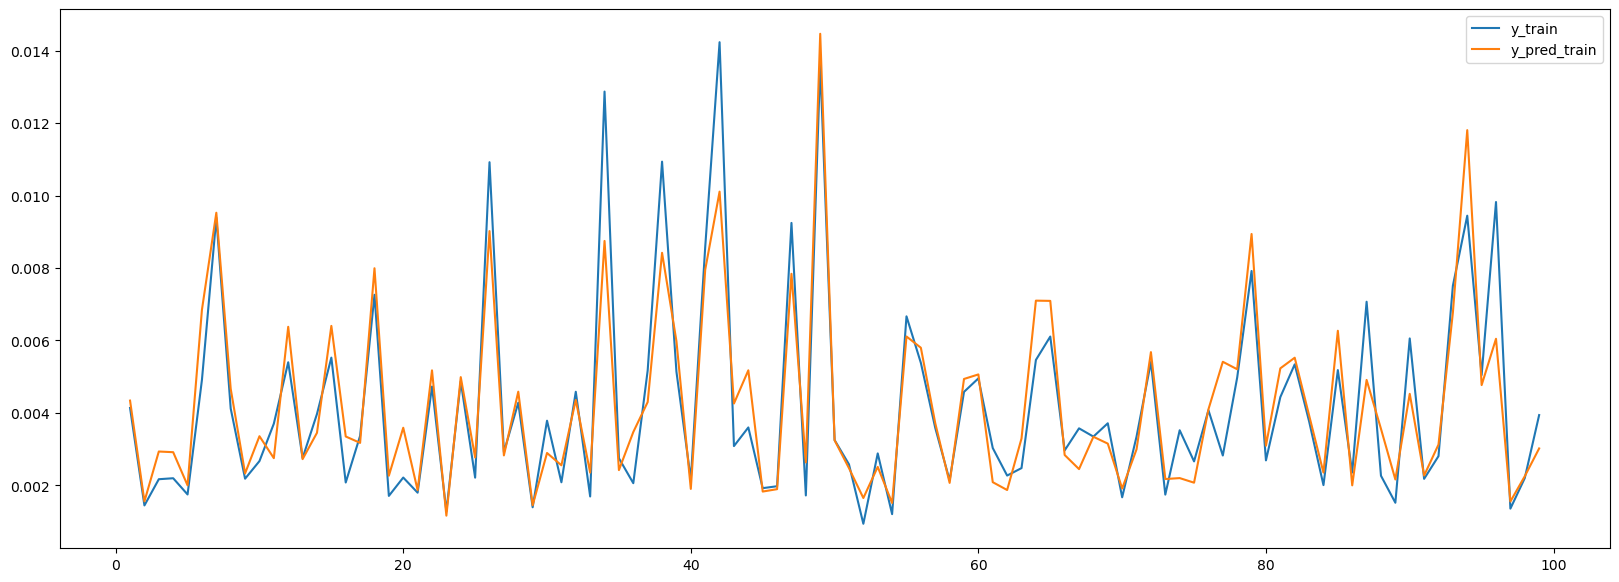

In [95]:
plt.figure(figsize=(20,7))
plt.plot(range(1,100),y_train.head(99),label='y_train')
plt.plot(range(1,100),y_pred_train[0:99],label='y_pred_train')
plt.legend()

# Test metrics

In [96]:
y_pred_test = model.predict(X_test)

In [97]:
r2_score(y_test, y_pred_test)

0.8014011741062257

In [98]:
rmspe(y_test,y_pred_test)

0.26582383922501746

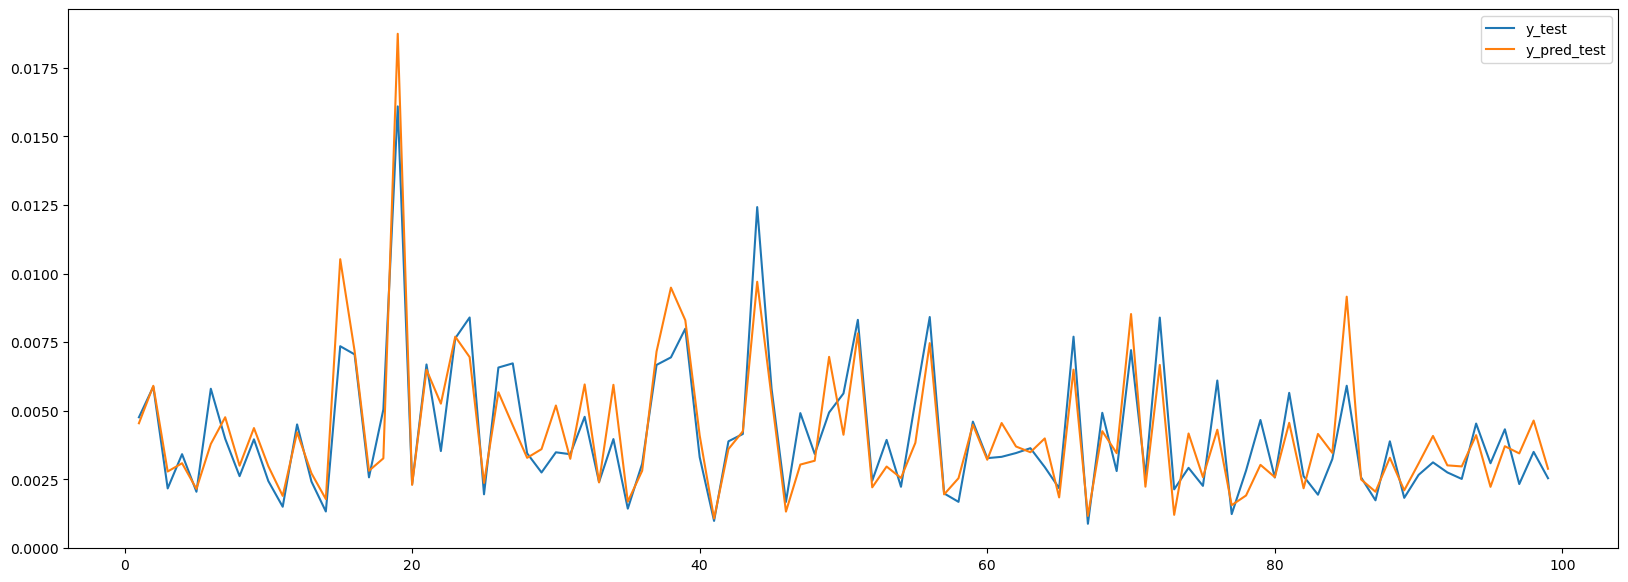

In [99]:
plt.figure(figsize=(20,7))
plt.plot(range(1,100),y_test.head(99),label='y_test')
plt.plot(range(1,100),y_pred_test[0:99],label='y_pred_test')
plt.legend()

Initial results indicate a significant improvement over the naive model, with R^2 increasing from 0.629 to 0.80 and RMSPE improving from 0.342 to 0.265. However, there appears to be a slight overfitting as evidenced by R^2 on the training set being 0.865, while on the test set it is 0.80. Additionally, RMSPE on the training set is 0.274, while on the test set it is 0.265, which is pretty good.

A possible solution to mitigate overfitting is to reduce the model's complexity by reducing the number of features and selecting the most relevant ones. In this case, since XGBoost is used, I choose the 'gain' importance type and select the top 70% of the most important features.

# Feature Importance

In [43]:
keys_values = model.get_booster().get_score(importance_type='gain')
keys = model.get_booster().get_score(importance_type='gain').keys()
values = model.get_booster().get_score(importance_type='gain').values()

In [44]:
model.get_booster().get_score(importance_type='gain')

{'total_size': 6.0239788581384346e-05,
 'mean_size': 0.00016725799650885165,
 'max_size': 8.017205254873261e-05,
 'min_size': 3.32256022375077e-05,
 'var_size': 0.00016957010666374117,
 'mean_price': 3.8854013837408274e-05,
 'max_price': 8.342596265720204e-05,
 'min_price': 6.750407192157581e-05,
 'var_price': 0.00021539664885494858,
 'total_volume': 8.260395406978205e-05,
 'mean_volume': 0.00026515914942137897,
 'max_volume': 4.900229396298528e-05,
 'min_volume': 8.398655336350203e-05,
 'var_volume': 0.0002654019626788795,
 'total_order_count': 0.00010075204772874713,
 'mean_order_count': 7.495870522689074e-05,
 'max_order_count': 6.366198067553341e-05,
 'var_order_count': 9.436145046493039e-05,
 'vwap': 5.6987646530615166e-05,
 'mean_vpc': 9.575934382155538e-05,
 'max_vpc': 7.638675015186891e-05,
 'min_vpc': 0.00013163397670723498,
 'var_vpc': 0.0001245973980985582,
 'mean_diff_sec': 0.00010113553435076028,
 'max_diff_sec': 0.00017091326299123466,
 'min_diff_sec': 8.06649259175174e-0

In [46]:
importance_df = pd.DataFrame({'Feature': keys, 'Importance': values})
fig = px.bar(importance_df, x='Importance', y='Feature', orientation='h', text='Importance')
fig.update_layout(title='Feature Importance Plot', xaxis_title='Importance', yaxis_title='Feature')
fig.show()

I extract the top 70% of the most important features based on the gain.

In [41]:
top_features = list(pd.Series(values, index = keys).nlargest(round(len(keys_values)*0.7)).index)

# Implementing XGB with these features

In [45]:
model.fit(X_train[top_features],y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [47]:
y_pred_train = model.predict(X_train[top_features])

# Training metrics

In [48]:
r2_score(y_train, y_pred_train)

0.8633451343700642

In [49]:
rmspe(y_train,y_pred_train)

0.2774265216286873

# Test metrics

In [51]:
y_pred_test = model.predict(X_test[top_features])

In [52]:
r2_score(y_test, y_pred_test)

0.7986592020064747

In [53]:
rmspe(y_test,y_pred_test)

0.2762052006026019

Reducing the model's complexity in this manner did not yield the expected results. In fact, the metrics on the training data remained unchanged, but the metrics on the test data worsened.

# Conclusion

I am satisfied with the achieved results, considering that the goal was to outperform a naive model. Further steps could include **hyperparameter tuning**, such as conducting a **grid search**, although computational constraints may limit this option. Additionally, model enhancement can be explored by **introducing** and **replacing** new variables. Alternatively, experimenting with different models or harnessing the power of neural networks could be considered.

The ideal objective would be to mitigate overfitting and reduce the RMSPE to below 0.2.